# S0. Introduction

Welcome to my Kaggle notebook for "Identifying Age-related Conditions", hosted by InVitro Cell Research, LLC (ICR). In this competition, we embark on a journey at the forefront of the growing field of bioinformatics, where data science meets cutting-edge medical research. Together, we aim to tackle critical challenges posed by age-related ailments and explore novel methods to improve predictive models for medical conditions.

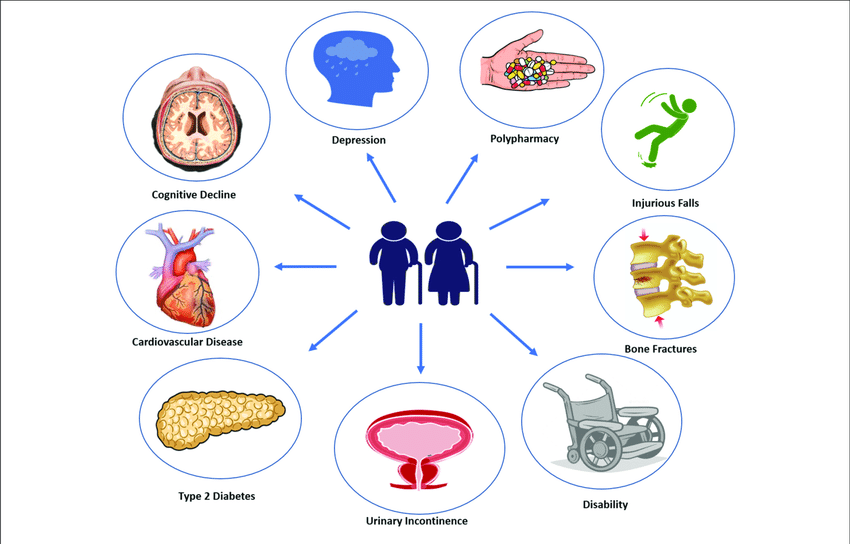

*The common clinical conditions associated with aging. Image source- Longo, M., Bellastella, G., Maiorino, M. I., Meier, J. J., Esposito, K., & Giugliano, D. (2019). Diabetes and aging: from treatment goals to pharmacologic therapy. Frontiers in Endocrinology, 10, 45.*

The problem statement of this competition tackles with the aging conundrum. Age, as they say, is just a number, but it brings with it a multitude of health issues. From heart disease and dementia to hearing loss and arthritis, aging is a significant risk factor for a range of debilitating diseases and complications. Understanding the intricate relationship between aging and various medical conditions is vital to advancing personalized medicine and improving the quality of life for aging individuals.

Bioinformatics stands as a beacon of hope, offering insights into interventions that may slow, reverse, or prevent the biological aging process. Through the analysis of diverse data sets, this field has the potential to revolutionize how we approach age-related ailments and develop targeted solutions for individuals based on their unique health characteristics.

## Evaluation Criteria:
Submissions are evaluated using a balanced logarithmic loss. The overall effect is such that each class is roughly equally important for the final score.

Each observation is either of class 0 or of class 1. For each observation, you must submit a probability for each class. The formula is then:

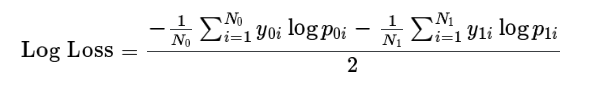


where (N_{c}) is the number of observations of class (c), (\log) is the natural logarithm, (y_{c i}) is 1 if observation (i) belongs to class (c) and 0 otherwise, (p_{c i}) is the predicted probability that observation (i) belongs to class (c).

The submitted probabilities for a given row are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, each predicted probability 
 is replaced with 


# S1. Importing Dependencies

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

/bin/bash: line 1: pip: command not found
mkdir: cannot create directory ‘/opt/conda’: Permission denied
cp: cannot stat '/kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt': No such file or directory


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import xgboost
import inspect
from collections import defaultdict
from tabpfn import TabPFNClassifier
import lightgbm as lgb
import warnings
from sklearn.model_selection import KFold as KF, GridSearchCV
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

env = 'local'

In [3]:
# ディレクトリの指定
if env == 'local':
    BASE_DIR = '../../data'
elif env == 'kaggle':
    BASE_DIR = '/kaggle/input/icr-identify-age-related-conditions/'
else:
    raise ValueError("Invalid environment. Set env as 'local' or 'kaggle'.")

# データの読み込み
# train_df = pd.read_csv(f'{BASE_DIR}/train.csv')
df_train = pd.read_csv(f'{BASE_DIR}/train_integerized.csv')
greeks = pd.read_csv(f'{BASE_DIR}/greeks.csv')
df_test = pd.read_csv(f'{BASE_DIR}/test.csv')
submission_1 = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

# S2. Exploratory Data Analysis (EDA)

In [4]:
df_train.sample(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
310,7c02caf1b94f,275.0,984585.5,16516.0,39901.0,1552.0,421.0,42.0,1230.0,175.0,...,0.765293,5633.5,10.0,3166.0,16439.0,234237.5,2535.0,18077.0,2.376000,0
572,ea50b3c5bd63,77.0,545124.0,9783.0,2292.0,1552.0,324.0,42.0,2523.0,927.0,...,2.811482,857.0,113.0,2608.0,28204.5,1831195.0,8782.0,26188.0,1.881000,0
490,c5f4dc4ae7fb,111.0,2015513.0,9783.0,11300.0,1552.0,662.0,42.0,539.0,723.0,...,20.986174,1858.0,79.0,2484.0,16439.0,571039.0,11431.0,7513.0,0.048712,1
320,800440b155b1,118.0,1126446.0,14276.0,16547.0,1552.0,636.0,42.0,1006.0,175.0,...,2.182514,1832.5,10.0,3897.0,16439.0,2981.0,9275.0,28325.0,0.625263,0
422,a7b1c7b83f53,149.0,232349.5,33456.0,32099.0,1552.0,799.5,112.5,759.0,175.0,...,4.142271,857.0,118.0,647.0,16439.0,405390.0,6614.0,1399.0,0.147231,0


In [5]:
df_train.shape

(617, 58)

The dataset has 58 dimensions (which can be reduced as we explore and analyse further) and 618 data entries. The class column indicated if a given person has any (one or multiple) of the three medical conditions (which are kept anonymous for obvious privacy reasons), or none. 

In [6]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,6.170000e+02,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,6.170000e+02,...,616.000000,6.170000e+02,615.000000,617.000000,617.000000,6.170000e+02,617.000000,617.000000,616.000000,617.000000
mean,111.666126,1.447113e+06,13620.910859,12582.677472,1931.396272,625.982172,99.047002,1676.681524,1145.846840,6.696356e+05,...,5.433199,6.092940e+03,62.232520,2228.000000,29820.010535,3.356103e+06,8462.702593,19667.354943,8.530961,0.175041
std,109.615804,9.505466e+05,14678.947104,22514.764634,2005.888114,288.034270,684.428383,690.359477,9272.473358,3.781385e+05,...,11.496257,8.652060e+04,192.730719,1074.167573,32642.409818,4.424545e+06,2650.964528,14100.408797,10.327010,0.380310
min,19.000000,7.958400e+04,9783.000000,1026.000000,1552.000000,79.000000,42.000000,539.000000,175.000000,2.119680e+05,...,0.173229,8.570000e+02,10.000000,441.000000,16439.000000,2.981000e+03,2535.000000,349.000000,0.001129,0.000000
25%,59.000000,9.079940e+05,9783.000000,3962.000000,1552.000000,466.000000,42.000000,1290.000000,175.000000,5.201130e+05,...,0.173229,8.570000e+02,10.000000,1509.000000,16439.000000,6.399160e+05,6728.000000,8947.000000,0.124392,0.000000
50%,83.000000,1.289388e+06,9783.000000,6630.000000,1552.000000,568.000000,42.000000,1660.000000,175.000000,6.255270e+05,...,3.028141,1.950000e+03,37.000000,2018.000000,16439.000000,1.792015e+06,8226.000000,15944.000000,0.337827,0.000000
75%,131.000000,1.802330e+06,13060.000000,12638.000000,1552.000000,726.000000,60.500000,2058.000000,723.000000,7.554300e+05,...,6.238814,2.607000e+03,79.000000,2753.000000,28886.500000,4.352014e+06,9907.000000,26412.000000,21.978000,0.000000
max,1442.000000,1.185462e+07,219327.500000,203590.000000,34123.500000,4320.000000,16939.000000,6184.000000,208266.000000,6.640876e+06,...,137.932739,2.145219e+06,4631.000000,14597.000000,338997.500000,3.287382e+07,21825.000000,74337.000000,21.978000,1.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

We can observe that EJ column is an object. Let's check what unique values it has, and let's see if we can encode them.

In [8]:
df_train.EJ.unique()

array(['B', 'A'], dtype=object)

As there are two categories, we will encode both as B- 0 and A-1

In [9]:
catB = df_train.EJ.unique()[0]
df_train.EJ = df_train.EJ.eq(catB).astype('int')
df_test.EJ = df_test.EJ.eq(catB).astype('int')

In [10]:
print(df_train.EJ.dtype)
print(df_train.EJ.unique())

int64
[1 0]


### Checking for null values

In [11]:
null_counts = df_train.isnull().sum()
null_counts

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [12]:
columns_with_nulls = null_counts[null_counts > 0].index.tolist()
columns_with_nulls

['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']

We **must** impute these columns with their mean to avoid any fortuitous errors that may occur during modelling. We will take care of them during modelling, as we can put an imputer function whilst making our class model

### Visualizations and plots:

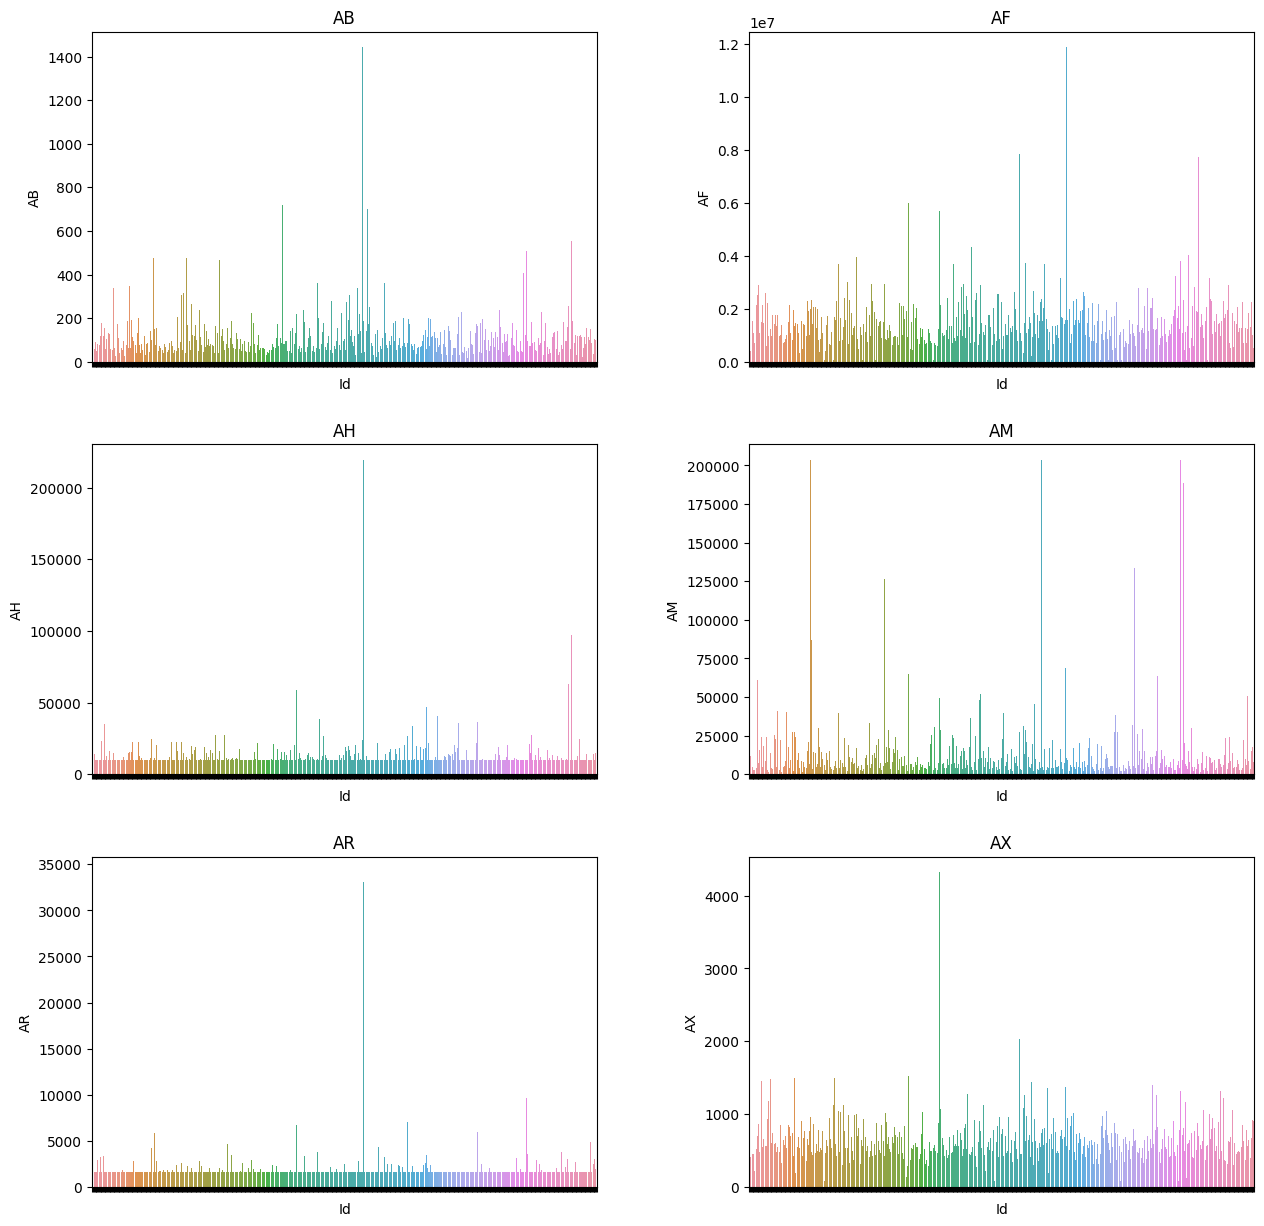

In [13]:
num_rows = 3
num_cols = 2
fig_size = (15, 15)

fig, axis = plt.subplots(num_rows, num_cols, figsize=fig_size)
numerical = [i for i in df_train.columns if i not in ["Id", "EJ", "Class"]]
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(numerical[:6]):
    row = i // num_cols
    col = i % num_cols
    
    bp = sns.barplot(ax=axis[row, col], x=df_train['Id'], y=df_train[column_name])
    bp.set(xticklabels=[])
    
    axis[row, col].set_title(column_name)

plt.show()

Let's plot a pie chart to check how many points are there for each class, to check if imbalance is present or not. 

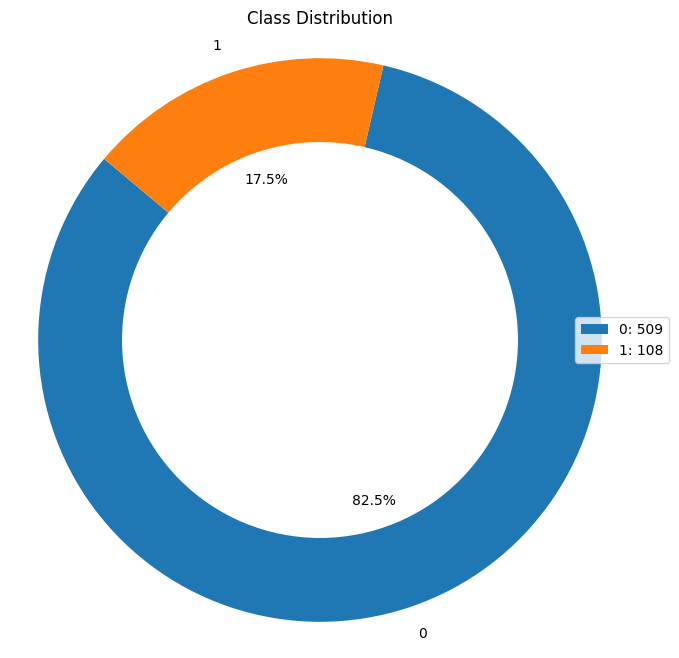

In [14]:
class_value_counts = df_train['Class'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(class_value_counts, labels=class_value_counts.index, autopct='%1.1f%%', startangle=140)

plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white'))
plt.legend(labels=[f'{class_name}: {count}' for class_name, count in class_value_counts.items()], loc='center left', bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.title('Class Distribution')
plt.axis('equal')
plt.show()

As the data is imbalanced, we can under-sample the majority class by reducing the number of instances in the majority class. This approach can be effective in reducing the computational burden and addressing the bias introduced by the class imbalance.
We can also take care of this, when we make our model class. 

# S3. Modelling (Using Gradient Boost Model and TabPFN)

First, let's take the feature columns and split them to train and test set

In [15]:
features = [col for col in df_train.columns if col != 'Class' and col != 'Id']
X = df_train[features]
y = df_train['Class']

In [16]:
X.shape

(617, 56)

In [17]:
y.shape

(617,)

Next, let's define the balanced log-loss evaluation criteria for our model.

In [18]:
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
  
    w_0 = 1 / N_0
    w_1 = 1 / N_1

    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
 
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))

    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)

    return balanced_log_loss/(N_0+N_1)

We will model by combining the powers of both Extreme Gradient Boosting Model (XGBoost) which is mostly used during Kaggle competiitions and TabPFN, very recently developed Transformer architecture presented in ICLR 2023. 


TabPFN is a revolutionary approach for tabular data classification, challenging the traditional method of fitting a new model from scratch to a training dataset. Instead, TabPFN utilizes a large pre-trained Transformer, which has been trained to solve various artificially generated classification tasks from tabular data prior. This method is built upon Prior-Data Fitted Networks (PFNs), which learn the training and prediction algorithm itself. PFNs approximate Bayesian inference and the posterior predictive distribution directly.

The prior used by TabPFN is based on Bayesian Neural Networks (BNNs) and Structural Causal Models (SCMs), which model complex feature dependencies and causal mechanisms in tabular data. The prior is designed with ideas from Occam's razor, favoring simpler SCMs and BNNs with fewer parameters. The PPD (Posterior Predictive Distribution) implicitly models uncertainty over all possible data-generating mechanisms, creating an infinitely large ensemble of data-generating mechanisms. TabPFN approximates this complex PPD in a single forward pass without the need for cross-validation or model selection.

TabPFN is a single Transformer that has been pre-trained to approximate probabilistic inference for the novel prior. It learns to solve small tabular classification tasks efficiently, typically involving datasets with up to 1,000 training examples, 100 purely numerical features without missing values, and 10 classes. Remarkably, it achieves state-of-the-art performance in less than a second.

The authors substantiate their claims by providing qualitative and quantitative analyses of TabPFN's behavior and performance on different tasks. It outperforms individual base-level classification algorithms like gradient-boosting methods (e.g., XGBoost, LightGBM, CatBoost) and competes with the best available AutoML frameworks in terms of performance but with significantly faster training times.

To validate their findings, the authors tested TabPFN on 18 small, numerical datasets and an additional 67 datasets from OpenML. They open-source all their code and the pre-trained TabPFN, along with a scikit-learn-like interface, a Colab notebook, and two online demos, to encourage scrutiny and adoption by the community.

Credits to the research paper source cited, and the notebooks of @vaibhavjain2004 and @siddhvr, for the hyperparameter coefficients of the XGBoost model and TabPFN.

*Source: Hollmann, N., Müller, S., Eggensperger, K., & Hutter, F. (2022). Tabpfn: A transformer that solves small tabular classification problems in a second. arXiv preprint arXiv:2207.01848.*

In [19]:
class Ensemble:
    def __init__(self):
        self.imputer = SimpleImputer(missing_values=np.nan, strategy='median') #missing values imputer
        # List of classifiers for the Ensemble
        self.classifiers = [
            xgboost.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.2, subsample=0.9, colsample_bytree=0.85),
            xgboost.XGBClassifier(),
            TabPFNClassifier(N_ensemble_configurations=128),
            TabPFNClassifier(N_ensemble_configurations=48)
        ]
    
    def fit(self, X, y):
        y = y.values
        unique_classes, y = np.unique(y, return_inverse=True)
        self.classes_ = unique_classes
        
        # converting binary categorical variable to integers
        first_category = X.EJ.unique()[0]
        X.EJ = X.EJ.eq(first_category).astype('int')
        
        # Imputing missing values in the feature data
        X = self.imputer.fit_transform(X)

        # Fit each classifier in the ensemble
        for classifier in self.classifiers:
            if classifier == self.classifiers[2] or classifier == self.classifiers[3]:
                classifier.fit(X, y, overwrite_warning=True)
            else:
                classifier.fit(X, y)
     
    def predict_proba(self, x):
        x = self.imputer.transform(x)
        
        probabilities = np.stack([classifier.predict_proba(x) for classifier in self.classifiers])
        
        # Average the probabilities from all classifiers
        averaged_probabilities = np.mean(probabilities, axis=0)
        
        # calculating the number of instances for class 0 and other classes
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1 / (class_0_est_instances if i == 0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        
        # Normalize the probabilities for final prediction
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)

In [20]:
cv_outer = KF(n_splits = 10, shuffle=True, random_state=42)
cv_inner = KF(n_splits = 5, shuffle=True, random_state=42)

In [21]:
def training(model, x, y, y_meta):
    # Initialize variables to store results and track best model and loss
    outer_results = []
    best_loss = np.inf
    split = 0
    splits = 5

    # Loop over cross-validation splits
    for train_idx, val_idx in tqdm(cv_inner.split(x), total=splits, desc="Outer CV Progress"):
        split += 1

        # Split data into training and validation sets
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y_meta.iloc[train_idx], y.iloc[val_idx]

        # Train the model on the current training set
        model.fit(x_train, y_train)

        # Predict probabilities for the validation set
        y_pred = model.predict_proba(x_val)

        # Process predicted probabilities to obtain binary predictions
        probabilities = np.concatenate((y_pred[:, :1], np.sum(y_pred[:, 1:], 1, keepdims=True)), axis=1)
        p0 = probabilities[:, :1]
        p0[p0 > 0.86] = 1  #86% and higher for 1
        p0[p0 < 0.14] = 0  #14% and lower for 0
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i] >= 0.5:
                y_p[i] = False
            else:
                y_p[i] = True
        y_p = y_p.astype(int)

        # Calculate balanced log loss (our evaluation criteria for the comp.) for the current split
        loss = balanced_log_loss(y_val, y_p)

        # Updating best_loss and best_model if current loss is lower
        if loss < best_loss:
            best_model = model
            best_loss = loss
            print('Best model saved during split %d' % split)

        outer_results.append(loss)
        print('Validation loss for split %d: %.5f' % (split, loss))

    # Calculate and print the mean of outer_results as the final evaluation metric
    mean_loss = np.mean(outer_results)
    print('Mean validation loss over %d splits: %.5f' % (splits, mean_loss))
    return best_model

# S4: Metadata (greeks) analysis

In [22]:
greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


Alpha Identifies the type of age-related condition, if present.

A No age-related condition. Corresponds to class 0.

B, D, G The three age-related conditions. Correspond to class 1.

Beta, Gamma, Delta Three experimental characteristics.

Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [23]:
from datetime import datetime
times = greeks.Epsilon.copy()
times[greeks.Epsilon != 'Unknown'] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x, '%m/%d/%Y').toordinal())
times[greeks.Epsilon == 'Unknown'] = np.nan

In [24]:
times

0      737137.0
1           NaN
2           NaN
3           NaN
4      737509.0
         ...   
612    737681.0
613    737676.0
614    737264.0
615    737090.0
616         NaN
Name: Epsilon, Length: 617, dtype: object

In [25]:
train_pred_time = pd.concat((df_train, times), axis=1)
test_predi = df_test[features]
catB = test_predi.EJ.unique()[0]
test_predi.EJ = test_predi.EJ.eq(catB).astype('int')
test_pred_and_time = np.concatenate((test_predi, np.zeros((len(test_predi), 1)) + train_pred_time.Epsilon.max() + 1), axis=1)

In [26]:
train_pred_time

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,Epsilon
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1,737137.0
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0,NaN
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0,NaN
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0,NaN
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1,737509.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,2174.0,10.0,964.0,49162.0,1850922.0,6622.0,26902.0,21.978000,0,737681.0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,2142.0,63.0,3859.0,112518.5,705374.5,7968.0,48526.0,0.145340,0,737676.0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,857.0,10.0,2146.0,29182.0,1480259.0,7032.0,46485.0,21.978000,0,737264.0
615,fe1942975e40,85.0,522122.0,9783.0,7648.0,1552.0,901.0,42.0,1194.0,175.0,...,1358.0,99.0,2644.0,16439.0,449324.0,6750.0,14446.0,0.184622,0,737090.0


In [27]:
ros = RandomOverSampler(random_state=42)
train_oversamp, y_oversamp = ros.fit_resample(train_pred_time, greeks.Alpha)

In [28]:
greeks.Alpha.value_counts()

Alpha
A    509
B     61
G     29
D     18
Name: count, dtype: int64

In [29]:
y_oversamp.value_counts() #Oversampled alpha 

Alpha
B    509
A    509
D    509
G    509
Name: count, dtype: int64

# S5: Training the Ensemble TabPFN + XGB

In [30]:
X_good = train_oversamp.drop(['Class', 'Id'],axis=1)
y_good = train_oversamp.Class

In [31]:
pfn_xgbmodel = Ensemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [32]:
m = training(pfn_xgbmodel,X_good,y_good,y_oversamp)

Outer CV Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Best model saved during split 1
Validation loss for split 1: 0.12283


/tmp/ipykernel_9177/1941216748.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


Best model saved during split 2
Validation loss for split 2: 0.00000


/tmp/ipykernel_9177/1941216748.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


Validation loss for split 3: 0.00000


/tmp/ipykernel_9177/1941216748.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


Validation loss for split 4: 0.13220


/tmp/ipykernel_9177/1941216748.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


Validation loss for split 5: 0.13386
Mean validation loss over 5 splits: 0.07778


In [33]:
y_good.value_counts()/y_good.shape[0]

Class
1    0.75
0    0.25
Name: count, dtype: float64

# S5: Testing Time: the moment of truth!

In [34]:
test_predictors = df_test[features].copy()
cat = test_predictors.EJ.unique()[0]
test_predictors.EJ = test_predictors.EJ.eq(cat).astype('int')
test_pred_and_time = np.concatenate((test_predictors, np.zeros((len(test_predictors), 1)) + train_pred_time.Epsilon.max() + 1), axis=1)

In [35]:
y_pred = m.predict_proba(test_pred_and_time)

/home/srs1123/ICR-Identifying-Age-Related-Conditions/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [36]:
df_test.shape

(5, 57)

In [37]:
probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
p0 = probabilities[:,:1]
p0[p0 > 0.59] = 1 
p0[p0 < 0.28] = 0

In [38]:
y_pred

array([[0.50000001, 0.25108075, 0.12979549, 0.11912375],
       [0.50000001, 0.25108075, 0.12979549, 0.11912375],
       [0.50000001, 0.25108075, 0.12979549, 0.11912375],
       [0.50000001, 0.25108075, 0.12979549, 0.11912375],
       [0.50000008, 0.25108068, 0.1297955 , 0.11912374]])

In [39]:
probabilities

array([[0.50000001, 0.49999999],
       [0.50000001, 0.49999999],
       [0.50000001, 0.49999999],
       [0.50000001, 0.49999999],
       [0.50000008, 0.49999992]])

In [40]:
submission = pd.DataFrame(df_test["Id"], columns=["Id"])
submission["class_0"] = p0
submission["class_1"] = 1 - p0
submission.to_csv('submission.csv', index=False)

In [41]:
submission_df = pd.read_csv('submission.csv')

pd.options.display.float_format = '{:.8f}'.format

print(submission_df)

             Id    class_0    class_1
0  00eed32682bb 0.50000001 0.49999999
1  010ebe33f668 0.50000001 0.49999999
2  02fa521e1838 0.50000001 0.49999999
3  040e15f562a2 0.50000001 0.49999999
4  046e85c7cc7f 0.50000008 0.49999992
